<a href="https://colab.research.google.com/github/nguyenanhtienabcd/AIO2024_EXERCISE/blob/feature%2FMODULE6-WEEK3/m06w03_ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
pip install unidecode

In [37]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
!gdown "1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q"
!unzip "/content/dataset.zip"

Downloading...
From: https://drive.google.com/uc?id=1uYXI4O3oWBA6QC8ZJ-r6yaTTfkdAnl_Q
To: /content/dataset.zip
100% 230k/230k [00:00<00:00, 28.8MB/s]
Archive:  /content/dataset.zip
replace dataset/all-data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [39]:
#read data
dataset_path = '/content/dataset/all-data.csv'
headers = ['sentiment', 'content']
df =  pd.read_csv(dataset_path, names=headers,
                  encoding = 'ISO-8859-1')
df.head()

,sentiment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [40]:
# phân loại class
classes = {
    class_name: idx for idx, class_name in enumerate(df['sentiment'].unique().tolist())
}
classes


{'neutral': 0, 'negative': 1, 'positive': 2}

In [41]:
df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])
df.head()

,sentiment,content
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,1,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


In [42]:
# Tiền xử lý dữ liệu
english_stopwords = set(stopwords.words('english'))
stemmer = PorterStemmer()

def text_normalization(text):
  text = text.lower() # chuyển tất cả các chữ về chữ thường
  text = unidecode.unidecode(text) # chuyển đổi các ký tự có dấu thành các ký tự không dấu
  text = re.sub(r'[^\w\s]','',text) # xóa các ký tự không mong muốn
  text = text.strip() # xóa các kỹ tự không cần hoặc các khoảng trắng ở trong câu
  text = ' '.join([word for word in text.split() if word not in english_stopwords])
  text = ' '.join([stemmer.stem(word) for word in text.split()])
  return text

In [43]:
df['content'] = df['content'].apply(lambda x: text_normalization(x))
df.head()

,sentiment,content
0,0,accord gran compani plan move product russia a...
1,0,technopoli plan develop stage area less 100000...
2,1,intern electron industri compani elcoteq laid ...
3,2,new product plant compani would increas capac ...
4,2,accord compani updat strategi year 20092012 ba...


In [44]:
# xây dựng bộ từ vựng
vocab = []
for sentence in df['content']:
  for token in sentence.split():
    if token not in vocab:
      vocab.append(token)
vocab.append('UNK')
vocab.append('PAD')
vocab = list(vocab)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)
print(vocab_size)


8908


In [45]:
def transform_text(text, word_to_idx, max_seq_len):
  tokens = []
  for token in text.split():
    try:
      idx = word_to_idx[token]
    except:
      idx = word_to_idx['UNK']
    tokens.append(idx)
  if len(tokens) < max_seq_len:
    tokens = tokens + [word_to_idx['PAD']] * (max_seq_len - len(tokens))
  else:
    tokens = tokens[:max_seq_len]
  return tokens

In [46]:
# chia bộ dữ liệu thành dữ liệu train, test, validate
val_size = 0.2
test_size = 0.125
is_shuffle = True

x = df['content'].tolist()
y = df['sentiment'].tolist()
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=val_size, shuffle=is_shuffle, random_state=seed)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size, shuffle=is_shuffle, random_state=seed)

In [47]:
# xây dựng lại bộ xử lý dữ liệu
class FinancialNews(Dataset):
  def __init__(self, x, y, word_to_idx, max_seq_len, transform=None):
    self.x = x
    self.y = y
    self.word_to_idx = word_to_idx
    self.max_seq_len = max_seq_len
    self.transform = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    text = self.x[idx]
    label = self.y[idx]
    if self.transform:
      text = self.transform(text, self.word_to_idx, self.max_seq_len)
    text = torch.tensor(text)
    label = torch.tensor(label)
    return text, label

In [48]:
# lấy dữ liệu
max_seq_len = 32

train_data = FinancialNews(x_train, y_train, word_to_idx, max_seq_len, transform=transform_text)
val_data = FinancialNews(x_val, y_val, word_to_idx, max_seq_len, transform=transform_text)
test_data = FinancialNews(x_test, y_test, word_to_idx, max_seq_len, transform=transform_text)

train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=test_batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=False)


In [49]:
# xây dựng mô hình
class SentimentClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout_prob):
    super(SentimentClassifier, self).__init__()
    # vocab_size =  số lượng của từ vựng
    # embedding_dim là số chiều của từng từ vựng
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.RNN = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
    self.norm = nn.LayerNorm(hidden_dim)
    self.dropout = nn.Dropout(dropout_prob)
    self.fc1 = nn.Linear(hidden_dim, 16)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(16, output_dim)

  def forward(self, x):
    x = self.embedding(x)
    x, hn = self.RNN(x)
    x = x[:, -1, :]
    x = self.norm(x)
    x = self.dropout(x)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

In [50]:
n_class = len(classes.keys())
embedding_dim = 64
hidden_dim = 64
n_layer = 2
dropout_prob = 0.2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


model = SentimentClassifier(vocab_size, embedding_dim, hidden_dim, n_class, dropout_prob).to(device)
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()


In [51]:
def evaluate(model, test_loader, criterion, device):
  model.eval()  # Set the model to evaluation mode
  correct = 0
  total = 0
  losses = []
  with torch.no_grad():
    for ind, (x_batch, y_batch) in enumerate(test_loader):
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      y_pred = model(x_batch)
      loss = criterion(y_pred, y_batch)
      losses.append(loss.item())
      # Get predicted labels by finding the index of the maximum value in each row of y_pred
      _, predicted = torch.max(y_pred, dim = 1)
      # Update total number of samples
      total += y_batch.size(0)
      # Update number of correctly classified samples
      correct += (predicted == y_batch).sum().item()

  cal_acc = correct / total
  cal_loss = np.mean(losses)
  return cal_loss, cal_acc

In [52]:
def fit(model, train_loader, val_loader, optimizer, criterion, n_epochs, device):
  losses_train, losses_val = [], []
  accs_train, accs_val = [], []
  for epoch in range(n_epochs):
    batch_train_losses = []
    batch_train_accs = []
    batch_train_accs = []
    model = model.train()
    for ind, (x_batch, y_batch) in enumerate(train_loader):
      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      optimizer.zero_grad()
      y_pred = model(x_batch)
      loss = criterion(y_pred, y_batch)
      loss.backward()
      optimizer.step()

      batch_train_losses.append(loss.item())
      batch_train_accs.append((y_pred.argmax(dim=1) == y_batch).sum().item()/y_batch.size(0))


    losses_train.append(np.mean(batch_train_losses))
    accs_train.append(np.mean(batch_train_accs))

    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    losses_val.append(val_loss)
    accs_val.append(val_acc)
    print(f'EPOCH {epoch + 1}:\tTrain loss : {losses_train[-1]:.4f}\tVal loss : {losses_val[-1]:.4f}')

  return losses_train, losses_val, accs_train, accs_val


In [53]:
epochs = 500
losses_train, losses_val, accs_train, accs_val = fit(model, train_loader, val_loader, optimizer, criterion, epochs, device)

EPOCH 1:	Train loss : 1.0487	Val loss : 0.9553
EPOCH 2:	Train loss : 0.9413	Val loss : 0.9292
EPOCH 3:	Train loss : 0.9317	Val loss : 0.9283
EPOCH 4:	Train loss : 0.9360	Val loss : 0.9283
EPOCH 5:	Train loss : 0.9312	Val loss : 0.9283
EPOCH 6:	Train loss : 0.9337	Val loss : 0.9283
EPOCH 7:	Train loss : 0.9337	Val loss : 0.9282
EPOCH 8:	Train loss : 0.9304	Val loss : 0.9285
EPOCH 9:	Train loss : 0.9308	Val loss : 0.9283
EPOCH 10:	Train loss : 0.9328	Val loss : 0.9283
EPOCH 11:	Train loss : 0.9341	Val loss : 0.9282
EPOCH 12:	Train loss : 0.9328	Val loss : 0.9282
EPOCH 13:	Train loss : 0.9302	Val loss : 0.9282
EPOCH 14:	Train loss : 0.9312	Val loss : 0.9282
EPOCH 15:	Train loss : 0.9342	Val loss : 0.9282
EPOCH 16:	Train loss : 0.9266	Val loss : 0.9282
EPOCH 17:	Train loss : 0.9314	Val loss : 0.9284
EPOCH 18:	Train loss : 0.9307	Val loss : 0.9282
EPOCH 19:	Train loss : 0.9291	Val loss : 0.9282
EPOCH 20:	Train loss : 0.9317	Val loss : 0.9282
EPOCH 21:	Train loss : 0.9338	Val loss : 0.9282
E

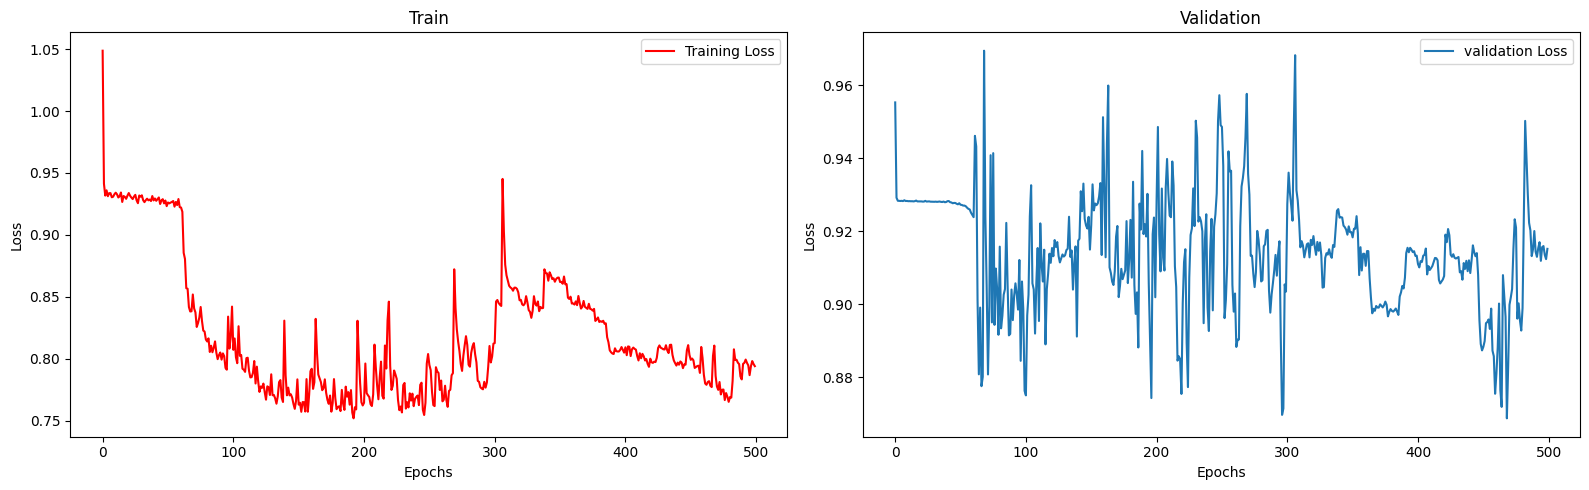

In [56]:
# prompt: tôi muốn tạo hai đồ thị loss để có thể so sánh trên cùng một hàng

import matplotlib.pyplot as plt

# Create the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Plot the first set of losses
ax[0].plot(losses_train, label='Training Loss', color = 'red')
ax[0].set_title('Train')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()


# Plot the second set of losses
ax[1].plot(losses_val, label='validation Loss')
ax[1].set_title('Validation')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

In [57]:
# prompt: đánh giá với với dữ liệu của tệp test

test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 0.8949, Test Accuracy: 0.5505
